In [378]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from pynvcenter import fields as f
# import fields_plot as fp
from pynvcenter import nv_optical_response as nv


import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

%matplotlib inline
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
import matplotlib


from itertools import combinations 
FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', titlesize=FONT_SIZE) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('lines', linewidth=2) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## summary of the most important functions

`esr_odmr_signal(f, co, c1, linewidth, fo, shot_noise=0)` <br>
calculates the odmr signal for a single NV transition according to 
\begin{equation}
s_i(\omega) = c - (c-c_o)\frac{\gamma^2}{(\omega-\omega_o)^2+\gamma^2},
\end{equation}
where $c$ is the count rate at resonance (i.e. minimum) in kCounts, $c_o$ the count rate of the background (i.e far away from $\omega_o$, $\omega_o$ is the resonance frequency and $\gamma$ the linewidth. Optionally, shot noise is added if `shot_noise` larger than 0. The `shot_noise` is the number corresponds to the measurement time in milliseconds, if the count rate $c_o$, $c$ are given in kCounts.
 <br> <br>


`esr_odmr_signal_ensemble(f, f_esr, contrast, avrg_count_rate=1, linewidth=1e7, shot_noise=0)` <br>
calculates the ensemble odmr according to 
\begin{equation}
s_\text{ens}(\omega) =\sum_i s_i(\omega),
\end{equation}
where $s_i(\omega)$ is the odmr of a single NV transition. The background counts and average count rate needed for $s_i(\omega)$ are calculated with `co, c = contrast_to_count_rates_max(contrast / 100, c)` ($c_o = \frac{1 - \mathcal{C}}{1 + \mathcal{C}} c$)
 <br> <br>



### approach 1 - contrast
`esr_2D_map_ring_scan(use_Pl=False)` <br>
calculates the esr map for an ensemble of NVs located on a ring in the xy plane centered at $\mathbf{r}_\text{NV} = (x_{\text{NV}},y_{\text{NV}},0)$. The magnetic field at the NVs is assumed to be generated by a magnetic dipole located at $\mathbf{r}_\text{dp} = (0,0,-h)$. The main parts of the calculation are
1. calculate the magnetic field at each NV position:<br>`bfields`
1. calculate the contast for each NV transition:<br>`esr_contrast = esr_contrast_ensemble(bfields, k_MW=MW_rabi, Dgs=Dgs)`
1. calculate the transtion frequencies for each NV transition:<br>`esr_freq = esr_frequencies_ensemble(bfields, Dgs=Dgs)`
1. calculate the odmr signal:<br>`esr_odmr_signal_ensemble(esr_freq, esr_contrast,avrg_count_rate,linewidth)`
<br><br>

`esr_contrast_ensemble` uses `photoluminescence_contrast()` to calculate the contrast for each NV transition.
<br><br>


`photoluminescence_contrast(Bfield, k12, k13, beta, kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4)` calculates the contrast following ref [1] using the level structure below

<img src="Tetienne_Fig1.jpg" width="400">


- There are only five intrinsic parameters, which are the rates kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4 in MHz with values are taken from [1].
- rates k12 (k13) correspoind to the Rabi frequencies between 0 and -1(+1) state in MHz
- $\beta$ is the optical pumping parameter and set to values around 1. Not that this paramter is a free fit parameter and not explicitely given in [1]
- Dgs=2.87 and Des=1.42 are the ground state and excited state zero field splitting
- Note that the singlet states are summarized into a *single metastable* level labelled 7.

The ground state Hamiltonian of the model is 
\begin{equation}
H_\text{gs} = 2\pi \hbar D_\text{gs} S_z^2+g\mu_B \mathbf{B}\cdot\mathbf{S},
\end{equation}
hence it doesn't account for strain splittings.
The excited level spin Hamiltonian $H_\text{es}$ is simply given by equation (3) while replacing $D_\text{gs}$ by $D_\text{es}$.
<br><br>


### approach 2 - PL
`esr_2D_map_ring_scan(use_Pl=True)` <br>
also calculates the esr map for an ensemble of NVs located on a ring in the xy plane centered at $\mathbf{r}_\text{NV} = (x_{\text{NV}},y_{\text{NV}},0)$. However, the main parts of the calculation are a little bit different and are: 
1. calculate the magnetic field at each NV position:<br>`bfields`
1. calculate the photoluminescence for each NV transition and the PL background:<br>`esr_PL = esr_PL_ensemble(bfields, k_MW=MW_rabi, Dgs=Dgs)`
1. calculate the transtion frequencies for each NV transition:<br>`esr_freq = esr_frequencies_ensemble(bfields, Dgs=Dgs)`
1. calculate the odmr signal:<br>`esr_odmr_signal_ensemble_PL(esr_freq, esr_pl,background_pl,linewidth)`
<br><br>

### approach 3 - PL2 (slow)
`esr_2D_map_ring_scan(use_Pl=True)` <br>
also calculates the esr map for an ensemble of NVs located on a ring in the xy plane centered at $\mathbf{r}_\text{NV} = (x_{\text{NV}},y_{\text{NV}},0)$. However, the main parts of the calculation are a little bit different and are: 
1. calculate the magnetic field at each NV position:<br>`bfields = b_field_single_dipole()`

For each magnetic field (lab frame)
2. calculate the magnetic field in the NV frame for each NV<br>
2. from this field calculate the esr transition frequencies  for each NV<br>
2. calculate the Rabi frequency for each esr transition assuming a Lorenzien centered at the transition frequency with a linewith $\gamma$:<br> `MW_rabi * lorenzian()`
2. for each Rabi frequency calculate the photoluminescence (PL): <br>`photoluminescence()`
<br><br>
[1] Tetienne et al. New Journal of Physics **14** (2012) 103033

## reproduce some figure from the literature

### esr frequencies as a function of azimuthal angle theta

(0, 360)

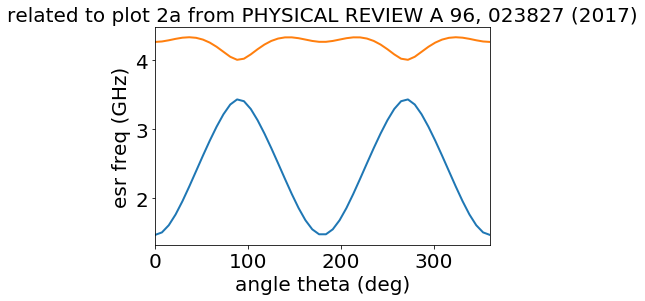

In [36]:
phi = 0
Bo=0.05

thetas = np.linspace(0,2*np.pi,50)

B = np.array([[
    Bo*np.cos(phi)*np.sin(theta),
    Bo*np.sin(phi)*np.sin(theta),
    Bo*np.cos(theta)
    
] for theta in thetas])

for b in nv.esr_frequencies(B).T:
    plt.plot(180/np.pi*thetas, b*1e-9)
    
plt.title('related to plot 2a from PHYSICAL REVIEW A 96, 023827 (2017)')
plt.xlabel('angle theta (deg)')
plt.ylabel('esr freq (GHz)')
plt.xlim([0,360])

### reproduce plot 2b from Tetienne et al.

New Journal of Physics 14 (2012) 103033 (http://www.njp.org/)

Text(0.5,1,'angle to Nv axis 74.0 deg')

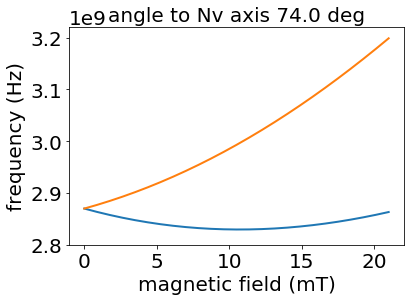

In [38]:
# angle 
theta = 74*np.pi/180
# field strength
B_mag = np.linspace(0,0.021,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T
f = nv.esr_frequencies(Bs)

plt.plot(B_mag*1e3, f[:,0])
plt.plot(B_mag*1e3, f[:,1])
plt.xlabel('magnetic field (mT)')
plt.ylabel('frequency (Hz)')
plt.ylim([2.8e9, 3.22e9])
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

### Tetienne Fig. 2a
We don't recover the asymmetry

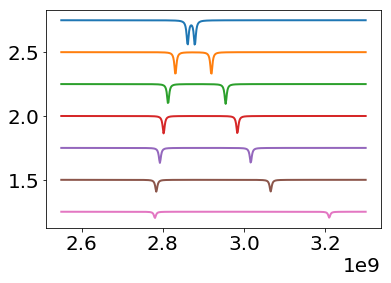

In [60]:
theta = 74*np.pi/180
# field strength
B_mag = np.array([0.8, 4, 6.4, 8.2, 10.1, 12.7, 19.3])*1e-3


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T

f = np.linspace(2.55, 3.3, 501)*1e9

esr_contrast = nv.esr_contrast_ensemble(B_lab=Bs, k_MW=10)

esr_freq = nv.esr_frequencies_ensemble(B_lab=Bs)

esr_contrast.shape, esr_freq

nv_id = 0
for bfield_id in range(len(Bs)):
    odmr  = nv.esr_odmr_signal_ensemble(f, esr_freq[bfield_id, nv_id], esr_contrast[bfield_id, nv_id],
                                        avrg_count_rate=1, linewidth=3e6, shot_noise=0)

    plt.plot(f, odmr+(len(Bs)-bfield_id)/4)
# nv.esr_odmr_signal(f, co, c1, linewidth, fo, shot_noise=0)

### Tetienne Fig. 2c
contrast for 1 and -1 transition

parameters Fig. 2c:
 - for -1 beta = 0.011, k12 = 1.2e+06 s^-1
 - for +1 beta = 0.015, k12 = 2.5e+05 s^-1

Text(0.5,1,'angle to Nv axis 57.0 deg')

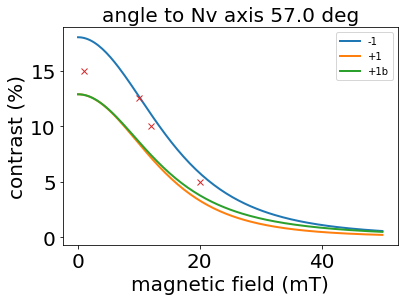

In [39]:
# angle 
theta = 57*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,151)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


Cm = nv.photoluminescence_contrast(Bfield=Bs, k12=1.2, k13=0, beta=0.011)
Cp = nv.photoluminescence_contrast(Bfield=Bs, k12=0.25, k13=0, beta=0.015)
Cp2 = nv.photoluminescence_contrast(Bfield=Bs, k12=0, k13=0.25, beta=0.015)
plt.plot(B_mag*1e3,Cm, label = '-1')
plt.plot(B_mag*1e3,Cp, label = '+1')
plt.plot(B_mag*1e3,Cp2, label = '+1b')

plt.plot([1, 10,12, 20],[15, 12.5,10,5], 'x')
plt.legend()
plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

### show the dips at the anticrossing

Text(0.5,1,'angle to Nv axis 1.0 deg')

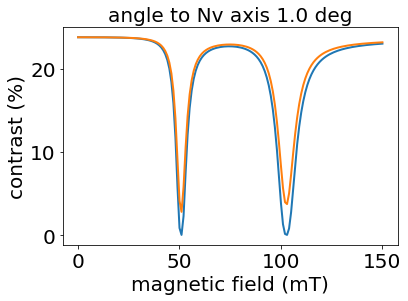

In [11]:
# angle 
theta = 57*np.pi/180
theta = 1*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.15,151)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


Cm = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=1)
Cp = nv.photoluminescence_contrast(Bfield=Bs, k12=0, k13=10, beta=1)
plt.plot(B_mag*1e3,Cm)
plt.plot(B_mag*1e3,Cp)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

Text(0.5,1,'angle to Nv axis 30.0 deg')

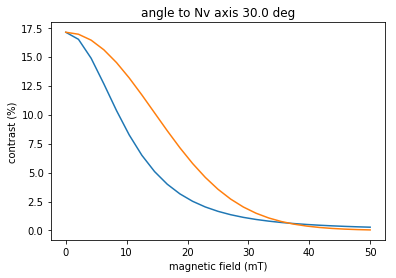

In [3]:
# angle 
# theta = 57*np.pi/180
theta = 74*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


C = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=2)
plt.plot(B_mag*1e3,C)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))






# angle 
# theta = 57*np.pi/180
theta = 30*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


C = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=2)
plt.plot(B_mag*1e3,C)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

### show contrast change for all four NV families

In [10]:
theta, phi = nv.nNV_angles[0]
theta, phi


(54.735610317244998, 135.0)

Text(0.5,1,'angle to Nv axis 54.7 deg')

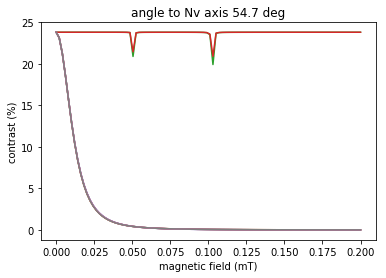

In [11]:
# angle 
# theta = 57*np.pi/180
theta = 54
phi = 0

# check that if the field is aligned with the NV the contrast stays constant
theta, phi = nv.nNV_angles[1]

theta = 54.7 # for small missalignment we get dips at the level crossings
# phi = 0

# convert to radias
theta *= np.pi/180
phi *= np.pi/180
# field strength
B_mag = np.linspace(0,0.20,100)


Bs = np.array([B_mag*np.sin(theta)*np.cos(phi), B_mag*np.sin(theta)*np.sin(phi), B_mag*np.cos(theta)]).T


for c in np.array([contrast.flatten() for contrast in nv.esr_contrast_ensemble(Bs)]).T:
    plt.plot(B_mag, c)
plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

In [16]:
for i in range(4):
    print(['f%d'%d for d in [i*2, i*2+1]])

['f0', 'f1']
['f2', 'f3']
['f4', 'f5']
['f6', 'f7']


### Tetienne Fig. 4

In [137]:
Bz = np.linspace(0,150, 151)*1e-3
Bperp = np.linspace(0,150, 151)*1e-3

X, Y = np.meshgrid(Bperp, Bz)

In [138]:
Bfield = np.vstack([np.zeros(len(X.flatten())), X.flatten(), Y.flatten()]).T
Bfield.shape

(22801, 3)

In [139]:
transition_rates = nv.transition_rate_matrix(Bfield)

In [140]:
populations = nv.populations(transition_rates)

np.array(transition_rates).shape, np.array(populations).shape

((22801, 7, 7), (22801, 7))

In [141]:
# transition_rates = nv.transition_rate_matrix(Bfield)
# populations = nv.populations(transition_rates)
pl_no_mw = nv.photoluminescence_rate(transition_rates, populations)

Text(0.5,1,'Fig 4a')

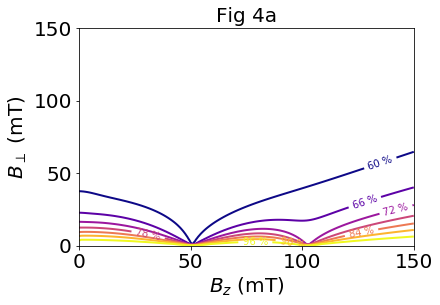

In [143]:
fig, ax = plt.subplots()
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
pl_no_mw = np.array(pl_no_mw).reshape(X.shape)
Z  = pl_no_mw/pl_no_mw.max()
CS = ax.contour(1e3*Y, 1e3*X, 100*Z, cmap='plasma')  # , cmap='hot', viridis

# Recast levels to new class
CS.levels = [nf(val) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'

ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)



plt.xlabel('$B_z$ (mT)')
plt.ylabel('$B_\perp$ (mT)')
# plt.colorbar()
plt.title('Fig 4a')

Text(0.5,1,'Fig 4a')

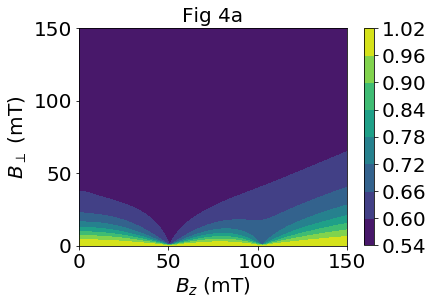

In [129]:
plt.contourf(1e3*Y, 1e3*X, Z/Z.max() )
plt.xlabel('$B_z$ (mT)')
plt.ylabel('$B_\perp$ (mT)')
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
plt.colorbar()

plt.title('Fig 4a')

#### compare with data from JP Tetienne

In [28]:
parameters = {
    'beta' : 5000 #   for 60 ps and 0 for 100 ns.  
}  




data_JP = np.loadtxt('../files_from_JP_Tetienne/PL_vs_Bperp_Bpara.txt')

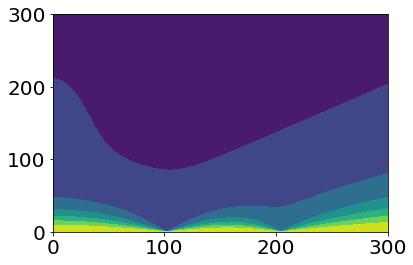

In [33]:
plt.contourf(data_JP.T)

## Comparing contrast vs directly fluorescence

### Single NV
magnetic field is defined in the NV frame, thus theta is the angle with the NV-axis

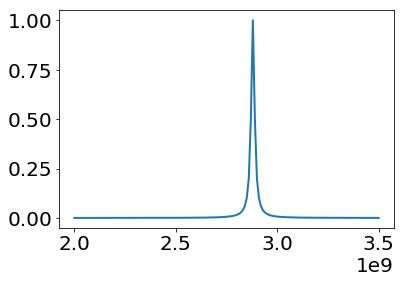

In [144]:

f = np.linspace(2.0, 3.5, 151)*1e9
signal = nv.lorenzian(f, linewidth=10e6, fo=2.88e9)
plt.plot(f, signal)

#### Photoluminescence

In [451]:
MW_rabi =10
linewidth=10e6
fo=2.87e9
beta=1


phi = 10

# convert to radias
phi *= np.pi/180
# field strength
B_mag = 0.020

thetas = np.linspace(0,45,91)


PLm = []
PLp = []
for theta in tqdm(thetas):
    theta *= np.pi/180  # convert to radias
    Bs = np.array([B_mag*np.sin(theta)*np.cos(phi), B_mag*np.sin(theta)*np.sin(phi), B_mag*np.cos(theta)]).T
    esr_freq = nv.esr_frequencies(np.expand_dims(Bs,0))[0]  # find the transition here the -1
    
    k12 = MW_rabi*lorenzian(f, linewidth=linewidth, fo=esr_freq[0])
    
    PLm.append([nv.photoluminescence(np.expand_dims(Bs,0), k, 0, beta=beta, kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4)[0]
               for k in k12])
    k13 = MW_rabi*lorenzian(f, linewidth=linewidth, fo=esr_freq[1])
    
    PLp.append([nv.photoluminescence(np.expand_dims(Bs,0), k, 0, beta=beta, kr=63.2, k47=10.8, k57=60.7, k71=0.8, k72=0.4)[0]
               for k in k13])
    
    
PLm = np.array(PLm)
PLp = np.array(PLp)

100%|██████████| 91/91 [00:41<00:00,  2.21it/s]


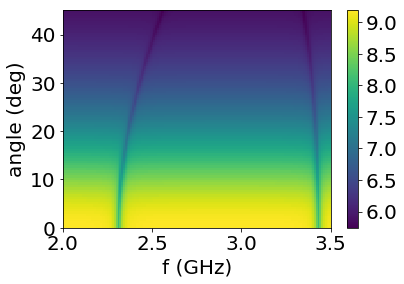

In [452]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, PLm+PLp)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

#### Contrast

In [453]:
sm = []
sp = []
for theta in thetas:
    
    theta *= np.pi/180
    Bs = np.array([B_mag*np.sin(theta)*np.cos(phi), B_mag*np.sin(theta)*np.sin(phi), B_mag*np.cos(theta)]).T
    
    
    esr_contrast = [nv.photoluminescence_contrast(np.expand_dims(Bs,0), k12=MW_rabi, k13=0, beta=beta)[0],
                    nv.photoluminescence_contrast(np.expand_dims(Bs,0), k12=0, k13=MW_rabi, beta=beta)[0]]
    esr_freq = nv.esr_frequencies(np.expand_dims(Bs,0))[0]
#     esr_contrast = nv.esr_contrast_ensemble(np.expand_dims(Bs,0), k_MW=MW_rabi)
#     esr_freq = nv.esr_frequencies_ensemble(np.expand_dims(Bs,0))
    
    
    
    co, c1 = nv.contrast_to_count_rates_max(esr_contrast[0] / 100, c1=4.5)
    sm.append(nv.esr_odmr_signal(f, co, c1, linewidth=linewidth, fo=esr_freq[0]))

    co, c1 = nv.contrast_to_count_rates_max(esr_contrast[1] / 100, c1=4.5)
    sp.append(nv.esr_odmr_signal(f, co, c1, linewidth=linewidth, fo=esr_freq[1]))


sm = np.array(sm)
sp = np.array(sp)







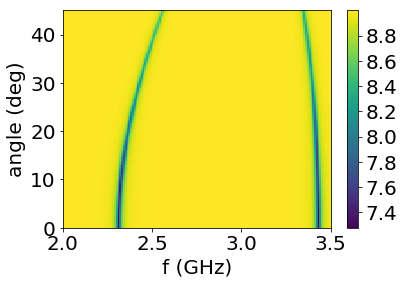

In [454]:
plt.pcolor(X*1e-9, Y, sm+sp)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

#### compare the two in a cross cut

conclusion: the PL signal is lower and has less contrast!!

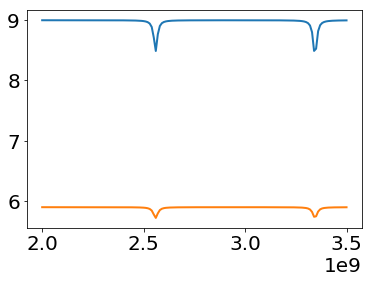

In [455]:
idx = 90
for s in [(sm+sp)[idx], (PLm+PLp)[idx]]:

#     plt.plot(f, s / s.max())
    plt.plot(f, s )

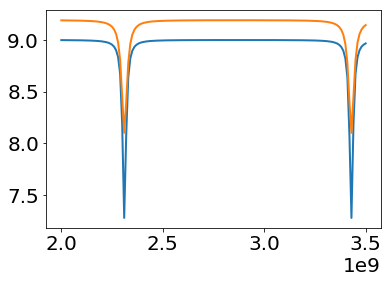

In [456]:
idx = 0
for s in [(sm+sp)[idx], (PLm+PLp)[idx]]:

#     plt.plot(f, s / s.max())
    plt.plot(f, s )

### Ensemble

now we define the field in the lab frame, hence theta is the angle to the z-axis

#### Contrast method

In [13]:
MW_rabi =10
linewidth=10e6
fo=2.87e9
beta=1


phi = 10

# convert to radias
phi *= np.pi/180
# field strength
B_mag = 0.020

thetas = np.linspace(0,45,91)
f = np.linspace(2.0, 3.5, 151)*1e9

In [14]:
%%time
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(phi), B_mag*np.sin(t)*np.sin(phi), B_mag*np.cos(t)]).T
signal_c = nv.signal_contrast(f, Bs, MW_rabi=MW_rabi, Dgs= 2.87, avrg_count_rate=4.5, linewidth=linewidth, shot_noise=0)

CPU times: user 1.72 s, sys: 19.7 ms, total: 1.74 s
Wall time: 1.82 s


In [15]:
Z = signal_c/signal_c.max() + 0.005*np.random.randn(*signal_c.shape)


In [17]:
esr_freq = nv.esr_frequencies_ensemble(Bs)

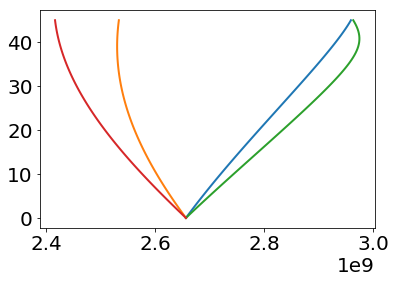

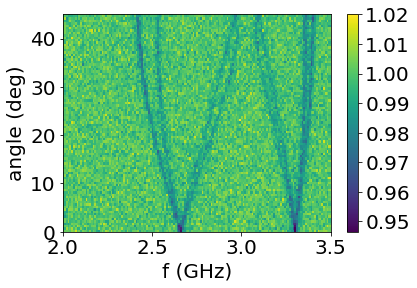

In [24]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, Z)

# for l in esr_freq[:,:,0].T:
#     plt.plot(l*1e-9,thetas, 'w--')

# for l in esr_freq[:,:,1].T:
#     plt.plot(l*1e-9,thetas, 'w--')
    
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

#### photoluminescence

In [185]:
%%time
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(phi), B_mag*np.sin(t)*np.sin(phi), B_mag*np.cos(t)]).T
signal = nv.signal_photoluminescence(f, Bs, MW_rabi=MW_rabi, Dgs= 2.87, linewidth=linewidth, shot_noise=0)


CPU times: user 1.21 s, sys: 11 ms, total: 1.23 s
Wall time: 1.24 s


In [186]:
f.shape, signal.shape

((151,), (91, 151))

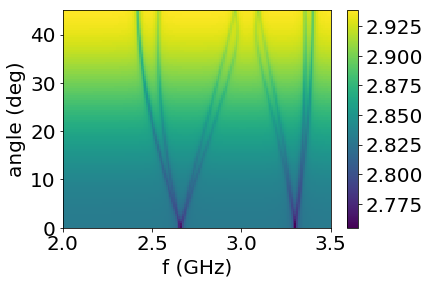

In [187]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, signal)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

adding noise

In [188]:
Z = signal/signal.max() + 0.005*np.random.randn(*signal.shape)

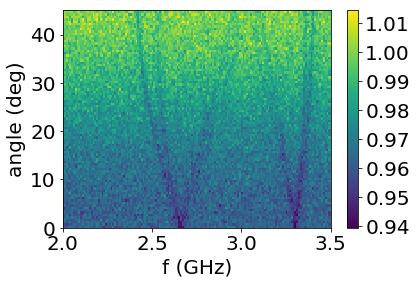

In [189]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, Z)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

normalize each row

In [190]:
np.tile([1,2,3],2)

array([1, 2, 3, 1, 2, 3])

In [191]:
X = np.vstack([[1,2,3,4],[1,2,3,4]]).T
print(X.shape)
X.flatten()

(4, 2)


array([1, 1, 2, 2, 3, 3, 4, 4])

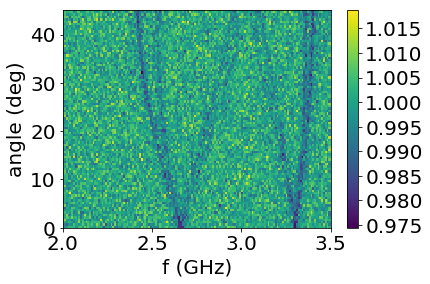

In [192]:

# Z=signal / np.tile(signal.mean(axis=1), (signal.shape[1],1)).T


Z=Z / np.tile(Z.mean(axis=1), (Z.shape[1],1)).T

X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, Z)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

In [148]:
from scipy.special import comb
import math

print(comb(4, 2, exact=True), ' possible combinations of NV lines')

6  possible combinations of NV lines


#### photoluminescence - 2 (slow)

In [12]:
%%time
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(phi), B_mag*np.sin(t)*np.sin(phi), B_mag*np.cos(t)]).T
signal = nv.signal_photoluminescence_2(f, Bs, MW_rabi=MW_rabi, Dgs= 2.87, linewidth=linewidth, shot_noise=0)

NameError: name 'f' is not defined

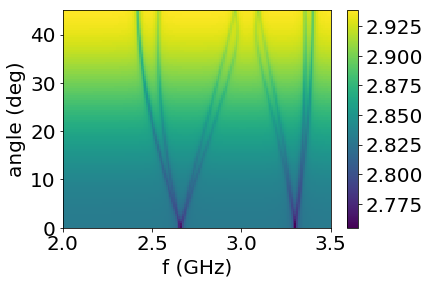

In [184]:
X, Y = np.meshgrid(f, thetas)
plt.pcolor(X*1e-9, Y, signal)
plt.xlabel('f (GHz)')
plt.ylabel('angle (deg)')
# plt.clabel('PL')
plt.colorbar()
# plt.title('Fig 4a')

## playing around

CPU times: user 468 ms, sys: 391 ms, total: 859 ms
Wall time: 1.6 s


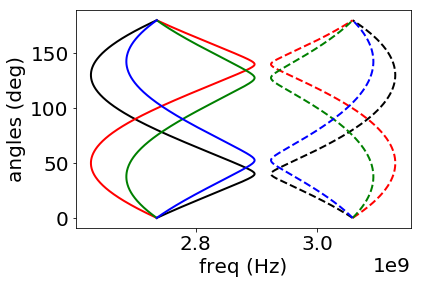

In [144]:
%%time
thetas = np.linspace(0,180,361)
phi=15
B_mag = 0.01

p = phi*180/np.pi
t =thetas*np.pi/180 
Bs = np.array([B_mag*np.sin(t)*np.cos(p), B_mag*np.sin(t)*np.sin(p), B_mag*np.cos(t)]).T
esr_freqs = nv.esr_frequencies_ensemble(Bs)

for l, c in zip(esr_freqs[:,:,0].T, ['k', 'r', 'g', 'b']):
    plt.plot(l, thetas, c)
for l, c in zip(esr_freqs[:,:,1].T, ['k', 'r', 'g', 'b']):
    plt.plot(l, thetas, c+'--')
    
plt.xlabel('freq (Hz)')
plt.ylabel('angles (deg)')

In [119]:
def hamiltonian_nv_spin1(Bfield=None, EDfield=None, gs=27.969, muB=1, hbar=1, D=nv._Dgs, d_perp = 17, d_par = 0.35):
    """
    The hamiltonian for a spin 1 system, this hamiltonian describes the NV gound state as well as the excited state
    :param Bfield: magnetic field in Tesla with components Bx, By, Bz: 1D-array of length 3 or 2D-array of dim Nx3
    :param Efield: electric or strain field
    :param gs: gyromagnetic ration (per Tesla)
    :param muB:
    :param hbar:
    :param D: (_Dgs for ground state, 1.42 for excited state) in GHz
    :param d_perp: perpedicular electric dipole components (Hz cm / V) from Doherty et al. Phys.Rep. 2013
    :param d_par: parllel electric dipole components (Hz cm / V)  from Doherty et al. Phys.Rep. 2013
    :return: the NV ground state hamiltonian
        3x3 matrix if input B-field is 1D-array
        Nx3x3 array if input B-field is 2D-array of length Nx3
    """

    # if the input is a 1D array we cast it into a 2D array to work with the rest of the code
    if len(np.shape(Bfield))==1:
        assert len(Bfield)==3
        Bfield = [Bfield]
        input_1D = True
    elif len(np.shape(Bfield))==2:
        assert np.shape(Bfield)[1]==3
        input_1D = False
    else:
        input_1D = False

    I = np.diag(np.ones(3))
    
    
    Sz2 = nv.Sz @ nv.Sz
    Sx2 = nv.Sx @ nv.Sx
    Sy2 = nv.Sy @ nv.Sy
    Sxy = nv.Sx @ nv.Sy
    Syx = nv.Sy @ nv.Sx
    
    # bare Hamiltonian
    Ho = hbar * D * Sz2
    
#     H = [hbar * D * Sz**2+gs*muB*(B[0]*Sx+B[1]*Sy+B[2]*Sz) for B in Bfield]
    
    # contriution from the magnetic field
    if Bfield is not None:
        H_b = [gs*muB*(B[0]*nv.Sx+B[1]*nv.Sy+B[2]*nv.Sz) for B in Bfield]
    else:
        H_b = 0
    
    # contriution from the electric field
    if EDfield is not None:
        H_e = [hbar * d_par* E[2] * Sz2 - hbar * d_perp* E[0] * (Sx2-Sy2) + hbar * d_perp*E[1] * (Sxy-Syx) for E in EDfield]
    else:
        H_e = 0
    

    Ho = np.array(Ho)
    H_b = np.array(H_b)
    H_e = np.array(H_e)
    
    

    H = Ho + H_b + H_e
    
    if input_1D:
        H = H[0]

    return H


Hgs = hamiltonian_nv_spin1(EDfield = np.array([[0.001,0,0]]))[0]

ev, Ugs = np.linalg.eigh(Hgs)
np.array([ev[1]-ev[0], ev[2]-ev[0]])
# ev


array([2.853, 2.887])

In [140]:

def angles(Ex, Ey, Bx, By, Bz):
    
    Ep = np.sqrt(Ex**2+Ey**2)
    phiE = np.arctan2(Ey, Ex)
    theta = np.arctan2(Ep, Bz)
    phiB = np.arctan2(By, Bx)
    
    return phiE, theta, phiB


def eigenstates_Sz(Ex, Ey, Bz):
    """
    Eq 33 from Doherty 2012
    
    """
    
    phiE, theta = angles(Ex, Ey, Bz)
    
    e0 = np.array([1,0,0]) # 0
    e1 = np.array([0,1,0]) #-1
    e2 = np.array([0,0,1]) # +1
    
    
    em = np.exp(1j * phiE/2)*np.sin(theta/2)*e2 + np.exp(-1j * phiE/2)*np.cos(theta/2)*e1
    ep = np.exp(1j * phiE/2)*np.cos(theta/2)*e2 - np.exp(-1j * phiE/2)*np.sin(theta/2)*e1
    
    return e0, em, ep


def hamiltonian_nv_spin1_Sz(B, E, D=2.87, gs=27.969, muB=1):
    """
    Eq. 34 Doherty - Hamiltonian in the basis of the Sz eigenstates (see eigenstates_Sz())
    """

    Bx, By, Bz = B*gs*muB
    Ex, Ey = E[0:2]*d_perp
    Eperp = np.sqrt(Ex**2+Ey**2)
    Bperp = np.sqrt(Bx**2+By**2)
    phiE, theta, phiB = angles(Ex, Ey, Bx, By, Bz)
    R = np.sqrt(Bz**2+Eperp**2)
    
    phi = 2*phiB+phiE
    
    
    
    x12 = np.exp(1j * phi/2)*np.sin(theta/2) + np.exp(-1j * phi/2)*np.cos(theta/2)
    x13 = np.exp(1j * phi/2)*np.cos(theta/2) - np.exp(-1j * phi/2)*np.sin(theta/2)
    x21 = np.exp(-1j * phi/2)*np.sin(theta/2) + np.exp(1j * phi/2)*np.cos(theta/2)
    x31 = np.exp(-1j * phi/2)*np.cos(theta/2) - np.exp(1j * phi/2)*np.sin(theta/2)
    
    H = [
        [0, Bperp/np.sqrt(2) * x12, Bperp/np.sqrt(2) * x13],
        [Bperp/np.sqrt(2) * x21, D-R, 0],
        [Bperp/np.sqrt(2) * x31, 0, D+R]
        
    ]

    return H
    

In [142]:
B = Bs[40]
E = np.array([0.001,0.002,0])
Hgs = hamiltonian_nv_spin1_Sz(B, E)
print(Hgs)
ev, Ugs = np.linalg.eigh(Hgs)
ev

[[0, (0.1891563110216801-0.1156250688537184j), (0.1870852913568632+0.11690502939794463j)], [(0.1891563110216801+0.1156250688537184j), 2.6668809026392997, 0], [(0.1870852913568632-0.11690502939794463j), 0, 3.0731190973607005]]


array([-0.0338624 ,  2.68437444,  3.08948796])

In [136]:
B

array([0.01118227, 0.        , 0.00726185])

In [81]:
np.expand_dims(B[0:2],axis=0) @ S

ValueError: shapes (1,2) and (2,3,3) not aligned: 2 (dim 1) != 3 (dim 1)

In [61]:
Hgs = hamiltonian_nv_spin1(Bs[40])

ev, Ugs = np.linalg.eigh(Hgs)
np.array([ev[1]-ev[0], ev[2]-ev[0]])

array([2.71814868, 3.1234039 ])

In [113]:
Hgs = nv.hamiltonian_nv_spin1(Bs[40])
ev, Ugs = np.linalg.eigh(Hgs)
np.array([ev[1]-ev[0], ev[2]-ev[0]])

array([2.71814868, 3.1234039 ])

In [114]:
Ugs

matrix([[ 9.94165537e-01+0.j        ,  7.83789277e-02-0.j        ,
          7.41055259e-02+0.j        ],
        [ 0.00000000e+00-0.08140805j,  8.88178420e-16+0.99592632j,
         -7.77156117e-16+0.03877499j],
        [ 1.05604818e-17-0.0707645j , -8.75483061e-16-0.04458155j,
          7.87996778e-16+0.9964963j ]])

In [56]:
nv.Sz**2

matrix([[0, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

In [57]:
nv.Sz

matrix([[ 0,  0,  0],
        [ 0, -1,  0],
        [ 0,  0,  1]])

# fit test

In [388]:
from pynvcenter import fields as f

def esr_ring_scan_freqs(angle, particle_radius=30, nv_radius=70, nv_x=0, nv_y=0, theta_mag=0, phi_mag=45,
                    dipole_height=80):
    """
        simulates the data from a ring scan
        particle_radius: particle_radius in um
         dipole_height = height of the dipole in um

         use_Pl: if True we calculate the photoluminescence if false the contrast (Warning this is outdated!!)
    """
    nv_po = np.array([nv_x, nv_y])  # center of ring where we measure the nvs

    Br = 0.1  # surface field of magnet in Tesla

    mu0 = 4 * np.pi * 1e-7  # T m /A

    dipole_strength = 4 * np.pi / 3 * (particle_radius) ** 3 / mu0
    
    # positions of NV centers
    nv_pos = np.array([nv_radius * np.cos(angle / 180 * np.pi) + nv_po[0],
                       nv_radius * np.sin(angle / 180 * np.pi) + nv_po[1]]).T

    # get physical units
    r = np.hstack([nv_pos, np.zeros([len(nv_pos), 1])])  # nvs are assumed to be in the z=0 plane
    DipolePosition = np.array(
        [0, 0, -dipole_height])  # position of dipole is at -dipole_position in z-direction and 0,0 in xy
    tm = np.pi / 180 * theta_mag
    pm = np.pi / 180 * phi_mag
    

    m = dipole_strength * np.array([np.cos(pm) * np.sin(tm), np.sin(pm) * np.sin(tm), np.cos(tm)])

    # calc field in lab frame
    bfields = f.b_field_single_dipole(r, DipolePosition, m)
    
    esr_freqs = nv.esr_frequencies_ensemble(bfields)
    
    return esr_freqs


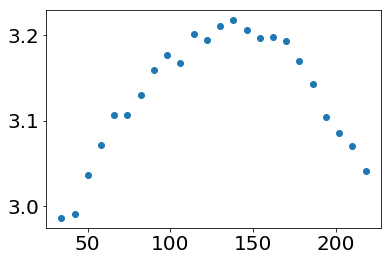

In [389]:

angles = np.arange(34, 220, 8)


x = esr_ring_scan_freqs(angle)[:,0,1]*1e-9  # the part of the esr that we identified
x += 0.01*np.random.normal(size=x.shape)
plt.plot(angle,x, 'o')

In [390]:

# from scipy.optimize import curve_fit

# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

# xdata = np.linspace(0, 4, 50)
# y = func(xdata, 2.5, 1.3, 0.5)
# np.random.seed(1729)
# y_noise = 0.2 * np.random.normal(size=xdata.size)
# ydata = y + y_noise
# plt.plot(xdata, ydata, 'b-', label='data')

# popt, pcov = curve_fit(func, xdata, ydata)
# popt

# plt.plot(xdata, func(xdata, *popt), 'r-',
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

### fit a single esr line over an arc

------=======------
[23.30192493 68.15776933  1.7996433   0.28384255  2.32936024  9.47846289
 28.4615842 ]


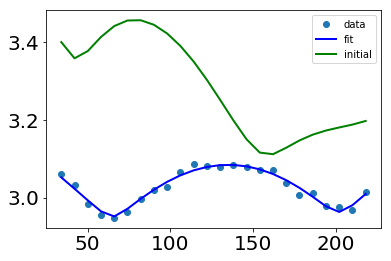

In [391]:

from scipy.optimize import minimize



def fit(angles, data, initial_guess):

    def loss(params):

        y = np.tile(data,4).reshape(-1, len(data)).T
        esr = esr_ring_scan_freqs(angles, *params)[:,:,1]*1e-9 
        err = np.sum((y-esr)**2, axis=0).min()

        return err

    return minimize(loss, initial_guess)
    
    
angle = np.arange(34, 220, 8)


x = esr_ring_scan_freqs(angle, particle_radius=30, nv_radius=70, nv_x=0, nv_y=0, theta_mag=0, phi_mag=45,
                    dipole_height=80)[:,1,1]*1e-9  # the part of the esr that we identified
x += 0.01*np.random.normal(size=x.shape)

initial_guess = np.array([28, 64, 0.2,0.2, 20, 10, 30])

print('------=======------')
result = fit(angles, x, initial_guess)


y = np.tile(x,4).reshape(-1, len(x)).T
y_pred = esr_ring_scan_freqs(angles, *result.x)[:,:,1]*1e-9
idx = np.sum((y_pred-y)**2, axis=0).argmin()


plt.plot(angles, x, 'o', label='data')
plt.plot(angles, y_pred[:,idx], 'b-', label='fit')


y_pred = esr_ring_scan_freqs(angles, *initial_guess)[:,:,1]*1e-9
idx = np.sum((y_pred-y)**2, axis=0).argmin()

plt.plot(angles, y_pred[:,idx], 'g-', label='initial')
plt.legend()



print(result.x)
# popt, pcov = curve_fit(func, xdata, ydata)
# print(popt)

# plt.plot(xdata, func(xdata, *popt), 'r-',
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

### two lines - approach 2

#### define the functions


In [438]:

from scipy.optimize import minimize



# def fit(angles, data, initial_guess):

#     def loss(params):

#         y = np.tile(data,4).reshape(-1, len(data)).T
#         esr = esr_ring_scan_freqs(angles, *params)[:,:,1]*1e-9 
#         err = np.sum((y-esr)**2, axis=0).min()

#         return err

#     return minimize(loss, initial_guess)


# from scipy.optimize import minimize



def fit(angles, data, initial_guess, Do=2.87, verbose=True):
    """
    angles/data: a vector of length N or a list of vectors each of length Ni
    initial_guess: dictionary where values are either single values or a list / tupple of values
    in the former case the parameter is not constraint, in the latter, the first value is the mean and the second the range of the bound
    
    """
    
    assert np.shape(angles) == np.shape(data)
    assert type(initial_guess) is dict
    
    bounds = [(v[0]-v[1]/2, v[0]+v[1]/2) if type(v) in (tuple, list) else (None, None) for k, v in initial_guess.items()]

    param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    
    # figure out if we recieved just a single set or several datasets
    if len(np.shape(data))==1 and len(np.shape(data[0]))==0:
        is_single = True
    else:
        is_single = False
    
    if verbose:
        print('is single:', is_single)
        
    # from now on we treat all the cases as a list of datasets
    if is_single:
        angles = [angles]
        data = [data]
    
    def loss(params):

        err, _, _ = loss_arcs({k:v for k,v in zip(initial_guess.keys(), params)}, angles, data)

        return np.sum(err)

    return minimize(loss, param_init, bounds=bounds)


    
def loss_arcs(params, angles, data):
    """
    
    params: magnet parameters as dictionary
    angles: list of list / vector containing the anges of the arc
    data: list of list / vector containing the measured esr frequencies for each angle
    
    
    returns: 
        err: error each element in the angles/data lists
        freqs: the esr freq predicted by the model
        ids_of_detected_esrs: the ids of the NV families corresponding to each element
    
    """
    
    

    for a, d in zip(angles, data):
        assert len(a)==len(d)
    
    # calculate the esr freq for current magnet parameters
    esr_freqs = [esr_ring_scan_freqs(_angles,**params)[:,:,1]*1e-9  for _angles in angles]

    # concat the data four time so that we can compare it with each ESR line
    esr_data = [np.tile(_data,4).reshape(-1, len(_data)).T for _data in data]

    
    ids_of_detected_esrs = []
    err = []
    freqs = []
    
    for _angles, _esr, _data in zip(angles, esr_freqs, esr_data):


            freq_diff = ((_data-_esr)**2) # squared difference between the predicted esrs (_esr) and the data (y)

            # only use the lines  that we haven't used yet
            freq_diff = freq_diff 
            _err = np.sum(freq_diff, axis=0)
            # get the smallest error considering only the lines that have not been used yet
            idx_err = list(_err).index(_err[[i for i in range(4) if i not in ids_of_detected_esrs]].min())

            ids_of_detected_esrs.append(idx_err)

            err.append(_err[idx_err])
            freqs.append(_esr[:,idx_err])
         
    # consistency check
    for a, f in zip(angles, freqs):
        assert len(a)==len(f)
        
    return err, freqs, ids_of_detected_esrs
    
#     err_of_combination = []
#     for _combination in combinations(range(4),len(angles)):
        
#         print('>>>>>> combination',_combination)
        
#         XXerr = 0

                
#         print('>>>>>> err', XXerr)
# #                 err.append(freq_diff[i for i in range(4) if i not in detected_ids].min())
# #                 freqs.append(y[freq_diff.argmin()])
# err, freqs, ids_of_detected_esrs = loss_arcs(magnet_params, angles, x)

#### generate the "data"

In [449]:
angle = np.arange(34, 220, 8)


magnet_params = {
    'particle_radius':27,
    'nv_radius':72.3,
    'nv_x':0.2,
    'nv_y':-0.5,
    'theta_mag':0,
    'phi_mag':45,
    'dipole_height':50
}

data = esr_ring_scan_freqs(angle, **magnet_params)[:,:,1]*1e-9  # the part of the esr that we identified
x =data + 0.003*np.random.normal(size=data.shape)
x = [x[:,0], x[5:17,2]]
angles = [angle, angle[5:17]]

------=======------
is single: False


#### fit to the data 

In [ ]:

initial_guess = {
    'particle_radius':(30,20),
    'nv_radius':(70,5),
    'nv_x':(0,2),
    'nv_y':(0,2),
    'theta_mag':(22,45),
    'phi_mag':(90,180),
    'dipole_height':(60,30)
}

print('------=======------')
result = fit(angles=angles, data=x, initial_guess=initial_guess)

# figure out if we recieved just a single set or several datasets
is_single = True if (len(np.shape(x))==1 and len(np.shape(x[0]))==0) else False

#### show the result

In [451]:

param_init = [v[0] if type(v) in (tuple, list) else v for v in initial_guess.values()]
df =pd.DataFrame.from_dict({
    'parameter set': ['actual', 'initial guess', 'fit'],
    **{k:[v1,v2,v3] for k, v1, v2, v3 in zip(magnet_params.keys(),magnet_params.values(), param_init ,result.x)}
})
df

,parameter set,particle_radius,nv_radius,nv_x,nv_y,theta_mag,phi_mag,dipole_height
0,actual,27.000000,72.3,0.200000,-0.50000,0.000000,45.000000,50.000000
1,initial guess,30.000000,70.0,0.000000,0.00000,22.000000,90.000000,60.000000
2,fit,27.097997,72.5,0.264881,-0.32903,0.895039,94.783539,51.528529


{'particle_radius': 27.09799689724455,
 'nv_radius': 72.5,
 'nv_x': 0.26488050798435364,
 'nv_y': -0.32903014374042605,
 'theta_mag': 0.8950388878654615,
 'phi_mag': 94.7835386587924,
 'dipole_height': 51.528529371772045}

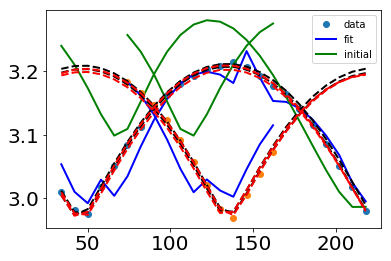

In [452]:
# for _a, _f in zip(angles, freq_pred):
#     plt.plot(_a, _f)
    
for i, (xo, ao) in enumerate(zip(x, angles)):
    y = np.tile(xo,4).reshape(-1, len(xo)).T
    y_pred = esr_ring_scan_freqs(ao, *result.x)[:,:,1]*1e-9
    idx = np.sum((y_pred-y)**2, axis=0).argmin()
    label='data' if i==0 else None
    plt.plot(ao, xo, 'o', label=label)
    
#     label='fit' if i==0 else None
#     plt.plot(ao, y_pred[:,idx], 'b-', label=label)
    label='fit' if i==0 else None
    plt.plot(ao, freq_pred[i], 'b-', label=label)
    
    param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    y_pred = esr_ring_scan_freqs(ao, *param_init)[:,:,1]*1e-9
    idx = np.sum((y_pred-y)**2, axis=0).argmin()
    label='initial' if i==0 else None
    plt.plot(ao, y_pred[:,idx], 'g-', label=label)

plt.legend()
for d in data.T:
    plt.plot(angle, d, 'k--')
    
data_pred =  esr_ring_scan_freqs(angle, *result.x)[:,:,1]*1e-9 
for d in data_pred.T:
    plt.plot(angle, d, 'r--')
{k:v for k, v in zip(magnet_params.keys(), result.x)}


### two lines - approach 1

In [174]:

magnet_params = {
    'particle_radius':30,
    'nv_radius':70,
    'nv_x':0,
    'nv_y':0,
    'theta_mag':0,
    'phi_mag':45,
    'dipole_height':80
}
x = esr_ring_scan_freqs(angle, **magnet_params)[:,:,1]*1e-9  # the part of the esr that we identified

In [341]:

from scipy.optimize import minimize



def fit(angles, data, initial_guess, Do=2.87, verbose=True):
    """
    angles/data: a vector of length N or a list of vectors each of length Ni
    initial_guess: dictionary where values are either single values or a list / tupple of values
    in the former case the parameter is not constraint, in the latter, the first value is the mean and the second the range of the bound
    
    """
    
    assert np.shape(angles) == np.shape(data)
    assert type(initial_guess) is dict
    
    bounds = [(v[0]-v[1]/2, v[0]+v[1]/2) if type(v) in (tuple, list) else (None, None) for k, v in initial_guess.items()]

    param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    
    # figure out if we recieved just a single set or several datasets
    if len(np.shape(data))==1 and len(np.shape(data[0]))==0:
        is_single = True
    else:
        is_single = False
    
    if verbose:
        print('is single:', is_single)
        
    # from now on we treat all the cases as a list of datasets
    if is_single:
        angles = [angles]
        data = [data]
    
    
        
    unique_angles = set([item for sublist in angles for item in sublist])
    unique_angles = np.array(sorted(list(unique_angles)))
#     print('unique_angles', unique_angles)
    
    
    def loss(params):

        err, _ = loss_arcs(params, angles, data, unique_angles = unique_angles)

        return err

    return minimize(loss, param_init, bounds=bounds)


    
def loss_arcs(params, angles, data, unique_angles = None):
    """
    
    params
    
    """
    
    
    if unique_angles is None:
        unique_angles = set([item for sublist in angles for item in sublist])
        unique_angles = np.array(sorted(list(unique_angles)))

    # calculate the esr freq for current magnet parameters
    esr = esr_ring_scan_freqs(unique_angles,*params)[:,:,1]*1e-9 

    err = []
    freqs = []
    # go over each unique angle
    for au, esr_au in zip(unique_angles, esr):
        # get the frequencies for each unique angle au
        freq_au = [xo[list(ao).index(au)] for ao, xo in zip(angles, data) if au in ao] 
        assert len(freq_au)<=4, print('there are max 4 NV families but got:', freq) 

        
#         print('())()()()()', len(freq_au))
        if len(freq_au)>1:
            # get all possible combinations 
            combs = list(combinations(range(4), len(freq_au)))
            y = np.array([esr_au[list(c)] for c in combs])
            freq_au = np.tile(freq_au,len(y)).reshape(len(y),-1)
            freq_diff = ((y-freq_au)**2) # differnence errors for all combinations
            
            
#             print('=============================================')
#             print('freq_diff.shape', freq_diff.shape)
#             print('lllll', freq_diff)

#             print('>>>>>' ,freq_diff.argmin())

#             print('min>>>>><<<<', freq_diff.min())
            
            _err =np.sum(freq_diff, axis=1) # sum over the freqs
            err.append(_err.min())
            freqs.append(y[_err.argmin()])
            

        else:  
            y = esr_au
            
            freq_diff = ((y-freq_au)**2)
            err.append(freq_diff.min())
            freqs.append(y[freq_diff.argmin()])
            
            
        

        
        
        
        
    err = np.sum(err)

    return err, freqs

In [342]:
    
# generate the "data"

angle = np.arange(34, 220, 8)


magnet_params = {
    'particle_radius':27,
    'nv_radius':72.3,
    'nv_x':0.2,
    'nv_y':-0.5,
    'theta_mag':0,
    'phi_mag':45,
    'dipole_height':50
}

data = esr_ring_scan_freqs(angle, **magnet_params)[:,:,1]*1e-9  # the part of the esr that we identified
x =data + 0.003*np.random.normal(size=data.shape)
x = [x[:,0], x[5:17,2]]
angles = [angle, angle[5:17]]


initial_guess = {
    'particle_radius':(30,20),
    'nv_radius':(70,5),
    'nv_x':(0,2),
    'nv_y':(0,2),
    'theta_mag':(45,90),
    'phi_mag':(90,180),
    'dipole_height':(60,30)
}
# initial_guess = np.array([28, 64, 0.2,0.2, 20, 10, 30])

print('------=======------')
result = fit(angles=angles, data=x, initial_guess=initial_guess)

# figure out if we recieved just a single set or several datasets
is_single = True if (len(np.shape(x))==1 and len(np.shape(x[0]))==0) else False



------=======------
is single: False


In [344]:
_unique_angles = set([item for sublist in angles for item in sublist])
_unique_angles = np.array(sorted(list(_unique_angles)))
_unique_angles

array([ 34,  42,  50,  58,  66,  74,  82,  90,  98, 106, 114, 122, 130,
       138, 146, 154, 162, 170, 178, 186, 194, 202, 210, 218])

In [375]:
err, _freq = loss_arcs(result.x, angles, x, unique_angles = _unique_angles)

freq_pred = [[f[i] if len(np.shape([f]))>= max(i+1,2) else f for f in _freq if len(np.shape([f]))>= i+1] for i in range(n_lines)]

In [373]:
f




NameError: name 'f' is not defined

{'particle_radius': 25.420381508090784,
 'nv_radius': 71.52857907285077,
 'nv_x': -0.004913460886599149,
 'nv_y': 1.0,
 'theta_mag': 34.76671763274367,
 'phi_mag': 93.78621257052586,
 'dipole_height': 45.19253960496092}

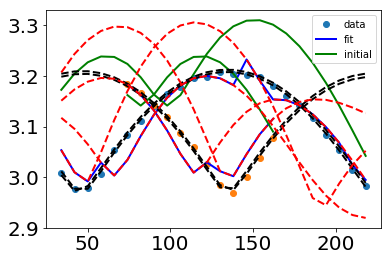

In [386]:
# for _a, _f in zip(angles, freq_pred):
#     plt.plot(_a, _f)
    
for i, (xo, ao) in enumerate(zip(x, angles)):
    y = np.tile(xo,4).reshape(-1, len(xo)).T
    y_pred = esr_ring_scan_freqs(ao, *result.x)[:,:,1]*1e-9
    idx = np.sum((y_pred-y)**2, axis=0).argmin()
    label='data' if i==0 else None
    plt.plot(ao, xo, 'o', label=label)
    
#     label='fit' if i==0 else None
#     plt.plot(ao, y_pred[:,idx], 'b-', label=label)
    label='fit' if i==0 else None
    plt.plot(ao, freq_pred[i], 'b-', label=label)
    
    param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
    y_pred = esr_ring_scan_freqs(ao, *param_init)[:,:,1]*1e-9
    idx = np.sum((y_pred-y)**2, axis=0).argmin()
    label='initial' if i==0 else None
    plt.plot(ao, y_pred[:,idx], 'g-', label=label)

plt.legend()
for d in data.T:
    plt.plot(angle, d, 'k--')
    
data_pred =  esr_ring_scan_freqs(angle, *result.x)[:,:,1]*1e-9 
for d in data_pred.T:
    plt.plot(angle, d, 'r--')
{k:v for k, v in zip(magnet_params.keys(), result.x)}

In [383]:
result.x

array([ 2.54203815e+01,  7.15285791e+01, -4.91346089e-03,  1.00000000e+00,
        3.47667176e+01,  9.37862126e+01,  4.51925396e+01])

{'particle_radius': 25.555197304678398,
 'nv_radius': 72.5,
 'nv_x': -0.24227158899205023,
 'nv_y': -0.06212334047488978,
 'theta_mag': 29.930922048923485,
 'phi_mag': 94.38440602053758,
 'dipole_height': 45.22973509099206}

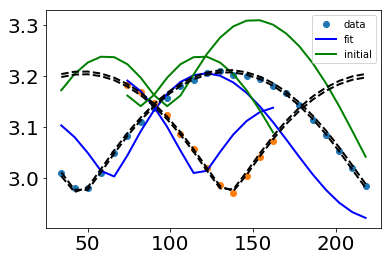

In [334]:
if is_single:
    y = np.tile(x,4).reshape(-1, len(x)).T
    y_pred = esr_ring_scan_freqs(angle, *result.x)[:,:,1]*1e-9
    idx = np.sum((y_pred-y)**2, axis=0).argmin()


    plt.plot(angle, x, 'o', label='data')
    plt.plot(angle, y_pred[:,idx], 'b-', label='fit')


    y_pred = esr_ring_scan_freqs(angle, *initial_guess)[:,:,1]*1e-9
    idx = np.sum((y_pred-y)**2, axis=0).argmin()

    plt.plot(angle, y_pred[:,idx], 'g-', label='initial')
    plt.legend()
else:
    for i, (xo, ao) in enumerate(zip(x, angles)):
        y = np.tile(xo,4).reshape(-1, len(xo)).T
        y_pred = esr_ring_scan_freqs(ao, *result.x)[:,:,1]*1e-9
        idx = np.sum((y_pred-y)**2, axis=0).argmin()
        label='data' if i==0 else None
        plt.plot(ao, xo, 'o', label=label)
        label='fit' if i==0 else None
        plt.plot(ao, y_pred[:,idx], 'b-', label=label)
        param_init = [v[0] if type(v) in (tuple, list) else v for k, v in initial_guess.items()]
        y_pred = esr_ring_scan_freqs(ao, *param_init)[:,:,1]*1e-9
        idx = np.sum((y_pred-y)**2, axis=0).argmin()
        label='initial' if i==0 else None
        plt.plot(ao, y_pred[:,idx], 'g-', label=label)

plt.legend()
for d in data.T:
    plt.plot(angle, d, 'k--')
{k:v for k, v in zip(magnet_params.keys(), result.x)}

In [330]:
magnet_params

{'particle_radius': 25,
 'nv_radius': 72.3,
 'nv_x': 0.2,
 'nv_y': -0.5,
 'theta_mag': 0,
 'phi_mag': 45,
 'dipole_height': 50}

{'particle_radius': 27.628673217697436,
 'nv_radius': 76.18661307469976,
 'nv_x': 23.644386085845607,
 'nv_y': 0.26789901089926693,
 'theta_mag': 25.010259126002417,
 'phi_mag': -2.8264328862773747,
 'dipole_height': 67.56537243183193}

In [240]:
{k:v for k, v in zip(magnet_params.keys(), initial_guess)}

{'particle_radius': 28.0,
 'nv_radius': 64.0,
 'nv_x': 0.2,
 'nv_y': 0.2,
 'theta_mag': 20.0,
 'phi_mag': 10.0,
 'dipole_height': 30.0}

In [241]:
magnet_params

{'particle_radius': 30,
 'nv_radius': 70,
 'nv_x': 0,
 'nv_y': 0,
 'theta_mag': 0,
 'phi_mag': 45,
 'dipole_height': 80}

In [75]:
ax = [angle, angle[0:5]]
dx = [x, x[0:5]]
if len(np.shape(d))==1 and len(np.shape(d[0]))==0:
    is_single = True
else:
    is_single = False
    
is_single

False

1